In [1]:
#import packaages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from pandas.api.types import CategoricalDtype
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
import statistics 
from sklearn.model_selection import KFold
from matplotlib import pyplot
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import csv
from pandas.plotting import scatter_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
#load daset
data = pd.read_csv('binarised_data.csv')

#removed unamed colummn
data = data.iloc[: , 1:]

#remove unwanted variables
data = data.drop(['ILP_R11', 'ILLB_R11', 'ILP_R'], axis= 1)


In [9]:
data.head()

,MAGER,WIC,BMI,PRIORLIVE,PRIORDEAD,PRECARE,RF_CESARN,RF_GDIAB,RF_PDIAB,RF_PHYPE,APGAR5,CIG_0,MRACEHISP,CIG_TOTAL,ILP_imp
0,32,0,24.2,0.0,0.0,2.0,0.0,0,0,0,0,0,3,0,0.0
1,34,0,30.9,0.0,0.0,3.0,0.0,1,0,0,0,1,0,1,0.0
2,31,0,23.8,2.0,0.0,3.0,0.0,0,0,0,0,0,3,0,45.0
3,33,0,25.0,2.0,0.0,2.0,0.0,0,0,0,0,0,0,0,31.0
4,26,0,23.3,0.0,0.0,3.0,0.0,0,0,0,0,0,5,0,0.0


### using label encoding

In [10]:
data2 = data

In [5]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13862938 entries, 0 to 13862937
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   MAGER      int64  
 1   WIC        int64  
 2   BMI        float64
 3   PRIORLIVE  float64
 4   PRIORDEAD  float64
 5   PRECARE    float64
 6   RF_CESARN  float64
 7   RF_GDIAB   int64  
 8   RF_PDIAB   int64  
 9   RF_PHYPE   int64  
 10  APGAR5     int64  
 11  CIG_0      int64  
 12  MRACEHISP  int64  
 13  CIG_TOTAL  int64  
 14  ILP_imp    float64
dtypes: float64(6), int64(9)
memory usage: 1.5 GB


In [12]:
# binarise binary variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data2['WIC'] = le.fit_transform(data2['WIC'])
data2['RF_GDIAB'] = le.fit_transform(data2['RF_GDIAB'])
data2['RF_PDIAB'] = le.fit_transform(data2['RF_PDIAB'])
data2['RF_PHYPE'] = le.fit_transform(data2['RF_PHYPE'])
data2['CIG_0'] = le.fit_transform(data2['CIG_0'])
data2['CIG_TOTAL'] = le.fit_transform(data2['CIG_TOTAL'])
data2['MRACEHISP'] = le.fit_transform(data2['MRACEHISP'])

In [15]:
## make it smaller
subset = data2.groupby('APGAR5', group_keys=False).apply(lambda x: x.sample(frac=0.0075))
len(subset)

103972

In [16]:
subset['APGAR5'].value_counts(normalize=True)*100

0    98.71023
1     1.28977
Name: APGAR5, dtype: float64

In [17]:
subset.to_csv('subset_binarised_0.0075.csv')

In [36]:
#define x and y
X = subset.drop(['APGAR5'], axis=1)
print(X.shape)
column_names = list(X.columns) 
print(column_names)

#y labels
y = subset['APGAR5']  ### change this to adapt to Apagr or pH as labels
print(y.shape)

(103972, 14)
['MAGER', 'WIC', 'BMI', 'PRIORLIVE', 'PRIORDEAD', 'PRECARE', 'RF_CESARN', 'RF_GDIAB', 'RF_PDIAB', 'RF_PHYPE', 'CIG_0', 'MRACEHISP', 'CIG_TOTAL', 'ILP_imp']
(103972,)


### feature selection

### RFE

In [23]:
# selected features
X = X[['BMI', 'PRIORLIVE', 'RF_PDIAB', 'RF_PHYPE', 'CIG_0', 'MRACEHISP', 'ILP_imp']]

In [19]:


def do_cv_learning(X, y, classifier, hyperparameter_space, verbose=False, 
                   do_scale=False, random_state=1,
                   scoring='roc_auc', folds=10, over_sampling=False):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    aucs = []
    ORs = []
    models = []
    cms = []

    X = np.array(X)
    y = np.array(y)
    if do_scale:
        sc = StandardScaler()
        X = sc.fit_transform(X)

    #what is the split ratio?
    for i, (train, test) in enumerate(cv.split(X, y)): 
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]

        # oversampling, only oversample training set
        if over_sampling:
          sm = SMOTE(random_state=random_state)
          X_train, y_train = sm.fit_resample(X_train, y_train)
        
        # do grid search on training
        gscv = GridSearchCV(classifier, hyperparameter_space, cv=5, 
                            scoring=scoring, n_jobs=-1)
        grid_result = gscv.fit(X_train, y_train)
        best_params = grid_result.best_params_
        if verbose:
            print('fold', i, 'best_params', best_params)

        # do the prediction on testing and collect results
        clf = grid_result.best_estimator_
        auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        cm = confusion_matrix(y_test, clf.predict(X_test))
        cms.append(cm)
        aucs.append(auc)
        print(y_test) ## added by Farah

        if hasattr(clf, 'coef_'):
            ORs.append([math.exp(c) for c in clf.coef_[0]])
        models.append(grid_result.best_estimator_)
    return aucs, cms, ORs, models

# get precision recall f1 from confusion matrix
def get_pr_f1(cm):
  tn, fp, fn, tp = cm.ravel()
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * precision * recall / (precision + recall)
  return precision, recall, f1

from sklearn.metrics import f1_score, roc_auc_score, make_scorer

# create a scorer by speicifying the pos label
from sklearn.metrics import precision_score, make_scorer
custom_scorer = make_scorer(f1_score, greater_is_better=True,  pos_label=1)


### PCA

In [37]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(X)

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit_transform(scaled_df)

array([[-0.08436906, -0.66752752,  0.86854272, -0.5729662 ,  0.25810786],
       [ 3.80789203, -3.18270483, -2.00635056,  0.47064764, -0.25243293],
       [-0.83303985, -1.81546291,  0.73925849,  0.24052366,  0.07613705],
       ...,
       [ 1.62225295,  2.6190782 ,  0.59703704, -0.8499279 ,  0.35067146],
       [-0.45823445,  0.19626582, -0.76077568,  5.05658824,  1.24005263],
       [ 0.3973329 ,  1.14264584,  0.48030567,  1.12185908, -2.57090143]])

In [39]:
print(sum(pca.explained_variance_ratio_))

0.5367553224873721


In [41]:
len(X.columns)

14

In [42]:
import numpy as np
nums = np.arange(14)

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_df)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

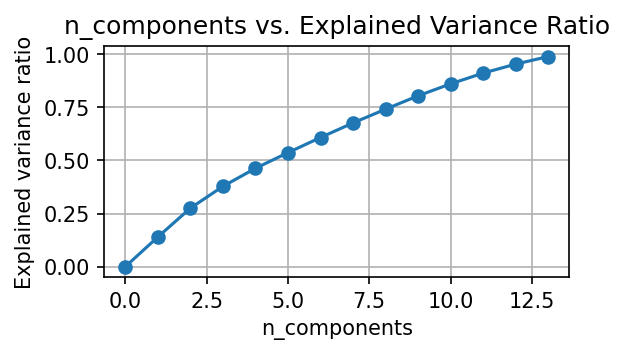

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(scaled_df)

In [45]:
# create RF classifier
random_state = 42
rf_clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
# set the hyperparameters and their search spaces
rf_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'criterion' : ['gini', 'entropy'], #added by me
    }

rf_aucs, rf_cms, _, _ = do_cv_learning(X_pca, y, rf_clf, rf_parameters, 
                                 scoring=custom_scorer, 
                                 folds=10,
                                 do_scale=True,
                                 over_sampling=True,
                                 verbose=True)


# result summary
rf_aucs = pd.DataFrame(rf_aucs, columns=['ROC-AUC']).describe()
rf_pr = pd.DataFrame([get_pr_f1(cm) for cm in rf_cms], columns=['precision', 'recall', 'f1']).describe()
rf_results = pd.concat([rf_aucs, rf_pr], axis=1)
rf_results.to_csv('rf_results_withencoder_wholedata.csv')

# print done message
print('done running random forest')

fold 0 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 1 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 2 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 3 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 4 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 5 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 6 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 7 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 8 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
fold 9 best_params {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
[0 0 0 ... 1 1 1]
done running random forest


In [46]:
rf_results

,ROC-AUC,precision,recall,f1
count,10.000000,10.000000,10.000000,10.000000
mean,0.542040,0.016042,0.108104,0.027934
std,0.019134,0.004431,0.032743,0.007812
min,0.517245,0.009512,0.059701,0.016410
25%,0.525302,0.013724,0.091418,0.023866
50%,0.542472,0.015783,0.104478,0.027421
75%,0.555878,0.019113,0.130597,0.033344
max,0.575097,0.024096,0.164179,0.042025


In [ ]:
#svm
#set random state for reproduction
random_state = 42

# create RF classifier
svm_clf = SVC (random_state= random_state, probability=True)
# set the hyperparameters and their search spaces
svm_parameters = {
        'kernel': ('linear', 'rbf', 'poly'), 
        'C': [1, 2, 5], 
        'gamma': ['auto', 'scale'], 
        'class_weight' : ['balanced', 'None']
        }

svm_aucs, svm_cms, _, _ = do_cv_learning(X_pca, y, svm_clf, svm_parameters, 
                                 scoring=custom_scorer, 
                                 folds=5,
                                 do_scale=True,
                                 over_sampling=True,
                                 verbose=True)

In [ ]:
# result summary
svm_aucs = pd.DataFrame(svm_aucs, columns=['ROC-AUC']).describe()
svm_pr = pd.DataFrame([get_pr_f1(cm) for cm in svm_cms], columns=['precision', 'recall', 'f1']).describe()
svm_results = pd.concat([svm_aucs, svm_pr], axis=1)
#svm_results.to_csv('rf_results_withencoder_wholedata.csv')

# print done message
print('done running random forest')

In [54]:
# create RF classifier
random_state = 42
mlp_clf = MLPClassifier(random_state = random_state )
# set the hyperparameters and their search spaces
mlp_parameters = {
    'hidden_layer_sizes' : [100, 150, 200, 250, 300, 350, 400],
    'activation' : ('identity', 'logistic', 'tanh', 'relu'),
    'solver' : ('adam', 'lbfgs', 'sgd'),
    'learning_rate' : ('constant', 'invscalling', 'adaptive'),
    }


mlp_aucs, mlp_cms, _, _ = do_cv_learning(X_pca, y, mlp_clf, mlp_parameters, 
                                 scoring=custom_scorer, 
                                 folds=5,
                                 do_scale=True,
                                 over_sampling=True,
                                 verbose=True)


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reach

KeyboardInterrupt: 

In [ ]:
# result summary
mlp_aucs = pd.DataFrame(mlp_aucs, columns=['ROC-AUC']).describe()
mlp_pr = pd.DataFrame([get_pr_f1(cm) for cm in mlp_cms], columns=['precision', 'recall', 'f1']).describe()
mlp_results = pd.concat([mlp_aucs, mlp_pr], axis=1)
mlp_results

In [56]:
#lg
# set random state for reproduction
import math
random_state = 42
from sklearn.linear_model import LogisticRegression

lg_predictor = LogisticRegression(random_state=random_state)
lg_parameters = {
    'penalty': ['l2'],
   'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }

lg_aucs, lg_cms,  _, _= do_cv_learning(X, y, lg_predictor, lg_parameters, 
                                 scoring='roc_auc', 
                                 folds=10,
                                 do_scale=True,
                                 over_sampling=True,
                                 verbose=True)

/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
T

fold 0 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anacond

fold 1 best_params {'penalty': 'l2', 'solver': 'lbfgs'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 2 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 3 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 4 best_params {'penalty': 'l2', 'solver': 'newton-cg'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anacond

fold 5 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 6 best_params {'penalty': 'l2', 'solver': 'newton-cg'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 7 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
T

fold 8 best_params {'penalty': 'l2', 'solver': 'liblinear'}
[0 0 0 ... 1 1 1]


/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/farahfrancis/opt/anaconda3/envs/EHR/lib/

fold 9 best_params {'penalty': 'l2', 'solver': 'saga'}
[0 0 0 ... 1 1 1]


In [57]:
# result summary
lg_aucs = pd.DataFrame(lg_aucs, columns=['ROC-AUC']).describe()
lg_pr = pd.DataFrame([get_pr_f1(cm) for cm in lg_cms], columns=['precision', 'recall', 'f1']).describe()
lg_results = pd.concat([lg_aucs, lg_pr], axis=1)
lg_results

,ROC-AUC,precision,recall,f1
count,10.000000,10.000000,10.000000,10.000000
mean,0.607582,0.017635,0.598817,0.034261
std,0.030732,0.001518,0.054722,0.002954
min,0.548892,0.015112,0.514925,0.029362
25%,0.598800,0.017318,0.586277,0.033642
50%,0.611640,0.017596,0.597015,0.034184
75%,0.621174,0.018399,0.617537,0.035733
max,0.652626,0.020206,0.701493,0.039281
